# **NLP Multi-Class Classification on Vacationers' Reviews**

-------
### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.metrics import plot_confusion_matrix, classification_report

-------
## Joining the Reviews and Listings Datasets

In [2]:
listings = pd.read_csv('../data/listings_cleaned.csv')

In [3]:
listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,reviews_per_month,city,state,zip_codes,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing,rating_target
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0.29,Boston,Massachusetts,2128,1.0,0,31,3,1,3
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0.90,Boston,Massachusetts,2119,1.0,0,30,4,1,2


In [4]:
reviews = pd.read_csv('../data/reviews_cleaned.csv', low_memory=False)

In [5]:
reviews.head(2)

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
0,3781,37776825,2015-07-10,36059247.0,Greg,The apartment was as advertised and Frank was ...,the apartment was as advertised and frank was ...
1,3781,41842494,2015-08-09,10459388.0,Tai,It was a pleasure to stay at Frank's place. Th...,it was a pleasure to stay at frank's place. th...


In [6]:
print(listings['id'].dtype)
print(reviews['listing_id'].dtype)

int64
object


-----
## Setting up the Target Column

In [7]:
reviews[reviews['listing_id'] == '<br/>june and john from barry south wales']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
35,<br/>june and john from barry south wales,the only reason i have not given 5stars is alt...,NaN,NaN,NaN,NaN,NaN
36,<br/>june and john from barry south wales,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
reviews[reviews['listing_id'] == '<br/>']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
44,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
46,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
62,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
65,<br/>,+ the room is wonderful and very clean,NaN,NaN,NaN,NaN,NaN
71,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
100919,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
101621,<br/>,philip was great! he helped us from the arriva...,NaN,NaN,NaN,NaN,NaN
101622,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
102123,<br/>,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
reviews[reviews['listing_id'] == '<br/>Enjoy.']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
45,<br/>Enjoy.,this is really a great location. the street is...,NaN,NaN,NaN,NaN,NaN


In [10]:
reviews[reviews['listing_id'] == '<br/>enjoy.']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
47,<br/>enjoy.,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
reviews[reviews['listing_id'] == '<br/>+ bathroom very nice and fully equipped']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
57,<br/>+ bathroom very nice and fully equipped,NaN,NaN,NaN,NaN,NaN,NaN
66,<br/>+ bathroom very nice and fully equipped,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(f'listings shape: {listings.shape}')
print(f'reviews shape: {reviews.shape}')

listings shape: (10664, 55)
reviews shape: (232218, 7)


In [13]:
reviews['lower_comments'].isnull().sum()

4727

In [14]:
reviews.isnull().sum()

listing_id           0
review_id         3045
date              3874
reviewer_id       3874
reviewer_name     3875
comments          3889
lower_comments    4727
dtype: int64

In [15]:
# filtering out any columns with letters for listing id
reviews[reviews['listing_id'].str.contains('[A-Za-z]') == True]

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
35,<br/>june and john from barry south wales,the only reason i have not given 5stars is alt...,NaN,NaN,NaN,NaN,NaN
36,<br/>june and john from barry south wales,NaN,NaN,NaN,NaN,NaN,NaN
44,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
45,<br/>Enjoy.,this is really a great location. the street is...,NaN,NaN,NaN,NaN,NaN
46,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
102131,<br/>close to everything. uncomplicated.,NaN,NaN,NaN,NaN,NaN,NaN
103350,<br/>Everything was very convenient and enjoya...,john and allie are very nice and responsible h...,NaN,NaN,NaN,NaN,NaN
103351,<br/>everything was very convenient and enjoya...,NaN,NaN,NaN,NaN,NaN,NaN
112335,<br/>For others who might end up booking this ...,ann made us feel very (website hidden by airbn...,NaN,NaN,NaN,NaN,NaN


In [16]:
# ~3,800 rows (out of ~230,000 total) with incorrect listing id and null column values
# drop these from the data frame
# the below code was adapted from jezrael's response on stack overflow at https://stackoverflow.com/questions/50134687/filter-all-rows-that-do-not-contain-letters-alpha-in-%C2%B4pandas%C2%B4 ()
reviews = reviews[reviews['listing_id'].str.contains('[A-Za-z]') == False].copy()

In [17]:
print(reviews.isnull().sum())

listing_id          0
review_id           0
date                0
reviewer_id         0
reviewer_name       1
comments           15
lower_comments    853
dtype: int64


In [18]:
# dropping remaining nulls in the cleaned comments column 
# and in the rating targets column
reviews.dropna(subset= 'lower_comments', inplace = True)
reviews.isnull().sum()

listing_id        0
review_id         0
date              0
reviewer_id       0
reviewer_name     1
comments          0
lower_comments    0
dtype: int64

In [19]:
listings['rating_target'].isnull().sum()

0

In [20]:
# ensure the columns to merge on are of the same data type
reviews['listing_id'] = reviews['listing_id'].astype(int)

In [21]:
# merge the two dataframes
df = pd.merge(left = listings, right = reviews, left_on= 'id', right_on= 'listing_id', )
df.shape

(628691, 62)

In [22]:
# make sure to not get any of the same reviews that happened to be pulled at a later date
df.drop_duplicates(['review_id'], inplace=True)

In [23]:
df.shape

(226530, 62)

In [24]:
df.to_csv('../data/merged.csv', index=False)

------
# **NLP Modeling of the Reviews**

#### *Start with Naive Bayes - including default hyper paramaters (and small number of features)*

In [25]:
# define X and y
X = df['lower_comments']
y = df['rating_target']

# determining a baseline accuracy
print(y.value_counts())
print('*'*45)
print(y.value_counts(normalize=True))
print('*'*45)

print(f'Baseline Accuracy: {round(pd.Series(y.value_counts(normalize=True))[3]*100, 2)}%')


3    94690
2    68969
1    33697
4    29174
Name: rating_target, dtype: int64
*********************************************
3    0.418002
2    0.304459
1    0.148753
4    0.128786
Name: rating_target, dtype: float64
*********************************************
Baseline Accuracy: 41.8%


In [26]:
# train test split - stick with the default 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     stratify= y,
                                                    random_state= 42)

In [27]:
print(X_train.shape)
print(X_test.shape)

(169897,)
(56633,)


In [28]:
def build_pipeline(num_features, model_abbrev, instance, X_train, y_train, X_test, y_test ):
    '''
    This function builds a pipeline
    instantiates and fits the model 
    and generates a confusion matrix
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(max_features = num_features)),
        (model_abbrev, instance)
    ])

    pipe.fit(X_train, y_train)
    print('Train:', pipe.score(X_train, y_train))
    print('Test:', pipe.score(X_test, y_test))

    return plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Reds');

# CVEC and NAIVE Bayes

Train: 0.4189244071407971
Test: 0.417442127381562


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


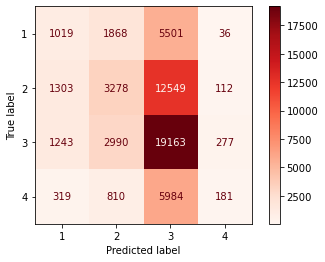

In [29]:
# try same number of features from EDA
build_pipeline(50, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

Train: 0.5779148542940723
Test: 0.5416453304610386


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


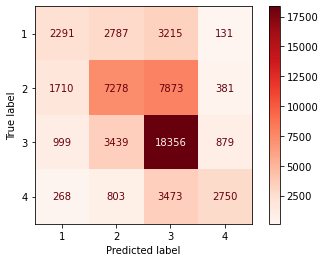

In [30]:
# check with results with many more features
build_pipeline(220000, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

Model misses the mark where it thinks the rating is between 4.8 and 4.95 (predicted 3), yet the observed rating actually falls between 4.59 and 4.8 (true label 2). 

# CVEC and Logistic Regression

Train: 0.4342572264371943
Test: 0.43365175780905124


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


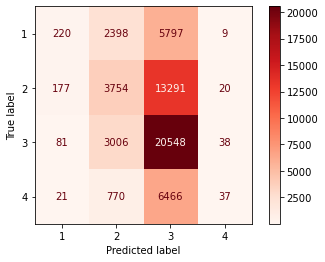

In [31]:
build_pipeline(50, 'logreg', LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs'), X_train, y_train, X_test, y_test)

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train: 0.6179567620381761
Test: 0.5648473504846997


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


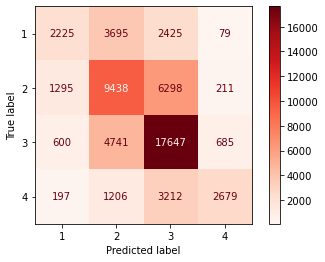

In [32]:
build_pipeline(220000, 'logreg', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'), X_train, y_train, X_test, y_test)

Again, the model misses the mark most where it thinks the rating is between 4.8 and 4.95 (predicted 3), yet the observed rating actually falls between 4.59 and 4.8 (true label 2). 

# CVEC and Random Forest

Train: 0.9069083032660965
Test: 0.4158352903784013


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


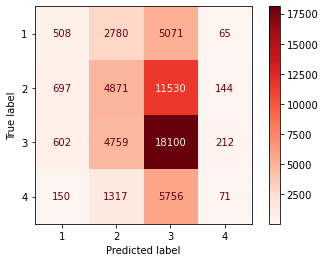

In [33]:
build_pipeline(50, 'rf', RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)

Train: 0.9713767753403533
Test: 0.4761887945190966


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


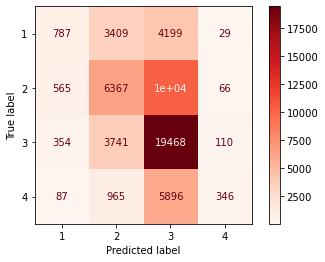

In [34]:
build_pipeline(220000, 'rf', RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)

The Random Forest model has a significant number of errors where it thinks the rating is between 4.8 and 4.95 (predicted 3), yet the observed rating is 4.59 or below (true label of 1).

# CVEC and Boosted Model

Train: 0.9319293454269352
Test: 0.3784719156675437


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


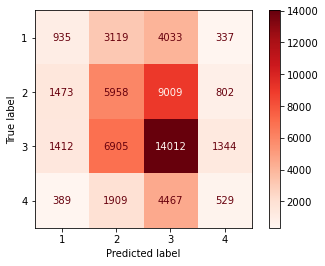

In [35]:
build_pipeline(100, 'ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), X_train, y_train, X_test, y_test)

-----
-----
### TF-IDF Vectorizer

In [36]:
def build_pipeline(num_features, model_abbrev, instance, X_train, y_train, X_test, y_test ):
    '''
    This function builds a pipeline
    instantiates and fits the model 
    and generates a confusion matrix
    '''
    pipe = Pipeline([
        ('tvec', TfidfVectorizer(max_features = num_features)),
        (model_abbrev, instance)
    ])

    pipe.fit(X_train, y_train)
    print('Train:', pipe.score(X_train, y_train))
    print('Test:', pipe.score(X_test, y_test))

    return plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Blues');

# TF-IDF and NAIVE Bayes

Train: 0.42090207596367213
Test: 0.4210795825755302


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


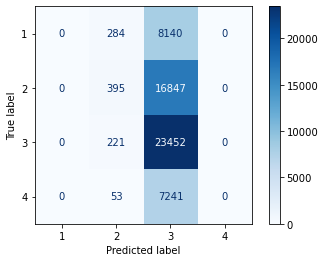

In [37]:
# try same number of features from EDA
build_pipeline(50, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

Train: 0.5213688293495471
Test: 0.4963360584818039


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


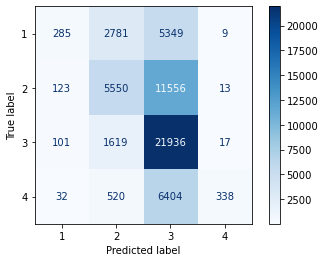

In [38]:
# check with results with many more features
build_pipeline(200000, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

# TF-IDF and Logistic Regression

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train: 0.6226360677351572
Test: 0.571115780551975


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


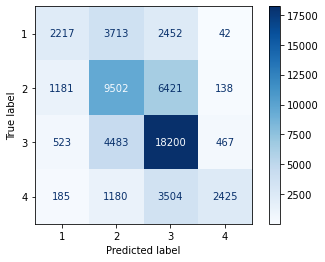

In [39]:
build_pipeline(220000, 'logreg', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'), X_train, y_train, X_test, y_test)

# TF-IDF and Random Forest

Train: 0.9713650035021218
Test: 0.4753059170448325


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


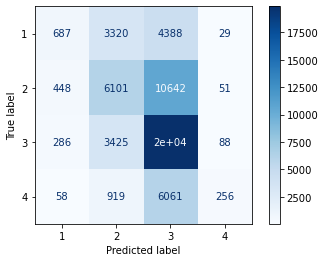

In [40]:
build_pipeline(200000, 'rf', RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)

The Ensemble models appear significantly overfit. Sticking to multinomial logistic regression for grid searching. 

# ***Grid searching***

In [41]:
# best model from above (multinomial logistic regression with Tf-IDF Vectorizer)
# try to improve through a grid search

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

params = {
    'tvec__max_features': [500, 10000, 100000],
    'tvec__stop_words': [None, 'english'],
    'log__penalty': [None, 'l2']
}

gs = GridSearchCV(pipe,
                 params,
                 cv = 3,
                 verbose = 1)

In [ ]:
# Fit the grid search model
gs.fit(X_train, y_train)

print(f'Training Cross-validated: {gs.best_score_}') # mean cross-validated training score
print(f'Test Score: {gs.score(X_test, y_test)}')

gs.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Training Cross-validated: 0.5647186288030903
Test Score: 0.5691734501085939


{'log__penalty': 'l2',
 'tvec__max_features': 100000,
 'tvec__stop_words': 'english'}

In [ ]:
# continuing to fine tune the model
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('log', LogisticRegression(multi_class='multinomial', 
                               solver='lbfgs', penalty = 'l2'))
])

params = {
    'tvec__max_features': [100000, 220000],
    'tvec__ngram_range': [(1,1), (1,2)],
    'log__max_iter': [100, 200]
}

gs = GridSearchCV(pipe,
                 params,
                 cv = 5,
                 verbose = 1)

In [ ]:
# Fit the grid search model
gs.fit(X_train, y_train)

print(f'Training Cross-validated: {gs.best_score_}') # mean cross-validated training score
print(f'Test Score: {gs.score(X_test, y_test)}')

gs.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Training Cross-validated: 0.5708046665806691
Test Score: 0.5724047816644006


{'log__max_iter': 200,
 'tvec__max_features': 100000,
 'tvec__ngram_range': (1, 1)}

Model did not perform very well on user reviews. See if NLP model on host descriptions performs better.